# Buat Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [15]:
# Load data
data = pd.read_csv("Data_Penjualan_Ritel.csv")
data['Trx Daily'] = pd.to_datetime(data['Trx Daily'])
data.set_index('Trx Daily', inplace=True)
data = data.resample('W').sum()

In [16]:
# Menambahkan fitur Moving Average (MA)
data['MA_Total_Trx'] = data['Total Transaksi'].rolling(window=4, min_periods=1).mean()

In [17]:
# Normalisasi data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[['Total Transaksi', 'Total Rev', 'Total Brt', 'MA_Total_Trx']])

In [18]:
# Fungsi untuk membuat sequence dengan window shifting
def create_sequences(data, seq_length=10, shift=1):
    X, y = [], []
    for i in range(0, len(data) - seq_length, shift):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # Prediksi Total Transaksi
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_sequences(data_scaled, seq_length, shift=1)

In [19]:
# Split data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [20]:
# Bangun model LSTM
model = Sequential([
    Bidirectional(LSTM(128, activation='tanh', return_sequences=True, input_shape=(seq_length, X.shape[2]))),
    Dropout(0.3),
    Bidirectional(LSTM(64, activation='tanh', return_sequences=True)),
    Dropout(0.3),
    LSTM(32, activation='tanh'),
    Dropout(0.3),
    Dense(1)
])

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
# Menggunakan AdamW dan callback untuk optimasi
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001), loss='mae')
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
]

In [22]:
# Train model
history = model.fit(X_train, y_train, epochs=500, batch_size=16, validation_data=(X_test, y_test), verbose=1, callbacks=callbacks)

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.7537 - val_loss: 0.9395 - learning_rate: 0.0010
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.7477 - val_loss: 0.9399 - learning_rate: 0.0010
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.7278 - val_loss: 0.9375 - learning_rate: 0.0010
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.7111 - val_loss: 0.9338 - learning_rate: 0.0010
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.6874 - val_loss: 0.9260 - learning_rate: 0.0010
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.6771 - val_loss: 0.9278 - learning_rate: 0.0010
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.6189 - val_loss: 0.9260 - learning_rate: 0.0010
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.6288 - val_loss: 0.9229 - learning_rate: 0.0010
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.6566 - val_loss: 0.9124 - learning_rate: 0.0010
Epoch 10/500
1/1 ━━━━━━━━━━━━━

In [23]:
# Prediksi
y_pred = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


In [24]:
# Konversi hasil prediksi ke skala asli
y_test_original = scaler.inverse_transform(np.c_[y_test, np.zeros((len(y_test), 3))])[:, 0]
y_pred_original = scaler.inverse_transform(np.c_[y_pred, np.zeros((len(y_pred), 3))])[:, 0]

# Buat DataFrame hasil prediksi
hasil_prediksi = pd.DataFrame({
    'Actual': y_test_original,
    'Predicted': y_pred_original
})

In [25]:
# Evaluasi
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test_original, y_pred_original)

print(f'Mean Absolute Error: {mae}')
print(f'R-squared Score: {r2}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')

Mean Absolute Error: 377.4425131333799
R-squared Score: 0.9087878812135534
RMSE: 440.71
MAPE: 10.42%


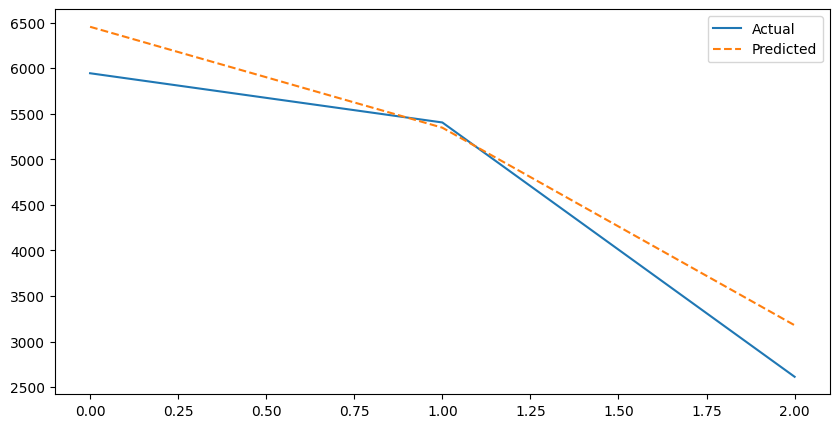

In [26]:
# Plot hasil
plt.figure(figsize=(10,5))
plt.plot(range(len(y_test)), y_test_original, label='Actual')
plt.plot(range(len(y_pred)), y_pred_original, label='Predicted', linestyle='dashed')
plt.legend()
plt.show()

# Menggunakan Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
Prediksi Total Revenue Minggu Berikutnya: 177577107.91
Hasil prediksi berhasil disimpan ke 'Prediksi_Mingdep.csv'


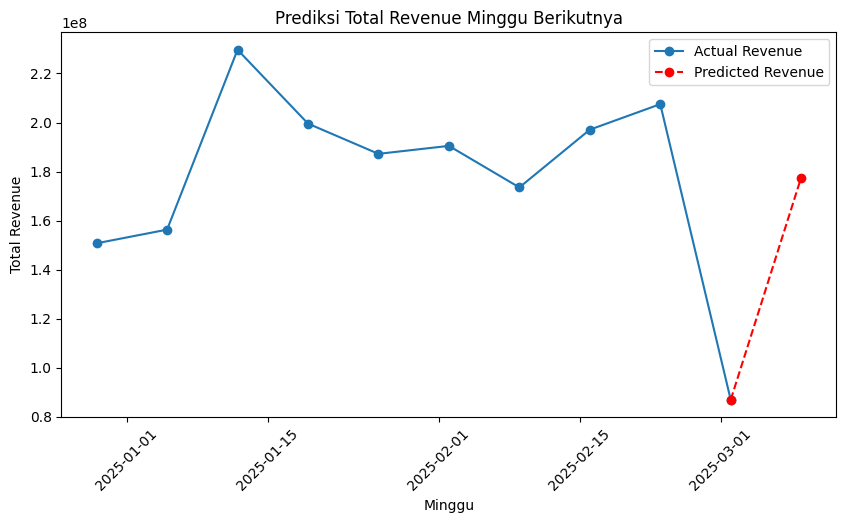

In [27]:
import matplotlib.pyplot as plt

# Ambil 10 minggu terakhir sebagai input prediksi
last_10_weeks = data_scaled[-seq_length:].reshape(1, seq_length, X.shape[2])

# Prediksi total transaksi minggu depan
next_week_prediction = model.predict(last_10_weeks)

# Inverse transform untuk mendapatkan nilai asli
next_week_predicted_values = scaler.inverse_transform(
    np.c_[next_week_prediction, np.zeros((1, 3))]
)[0]  

# Ambil Total Revenue dari hasil inverse transform
next_week_predicted_revenue = next_week_predicted_values[1]

print(f"Prediksi Total Revenue Minggu Berikutnya: {next_week_predicted_revenue:.2f}")

# Simpan hasil prediksi dalam DataFrame
hasil_prediksi_minggu_depan = pd.DataFrame({
    "Tanggal": [pd.to_datetime(data.index[-1]) + pd.Timedelta(weeks=1)],
    "Predicted Total Revenue": [next_week_predicted_revenue]
})

# Simpan ke CSV
hasil_prediksi_minggu_depan.to_csv("Prediksi_Mingdep.csv", index=False)
print("Hasil prediksi berhasil disimpan ke 'Prediksi_Mingdep.csv'")

# Tambahkan hasil prediksi ke dalam grafik
weeks = list(data.index[-10:]) + [hasil_prediksi_minggu_depan["Tanggal"][0]]
actual_revenues = list(data["Total Rev"].values[-10:]) + [next_week_predicted_revenue]

# Plot grafik
plt.figure(figsize=(10, 5))
plt.plot(weeks[:-1], actual_revenues[:-1], marker='o', label="Actual Revenue", linestyle='-')
plt.plot(weeks[-2:], actual_revenues[-2:], marker='o', label="Predicted Revenue", linestyle='dashed', color='red')

plt.xlabel("Minggu")
plt.ylabel("Total Revenue")
plt.title("Prediksi Total Revenue Minggu Berikutnya")
plt.legend()
plt.xticks(rotation=45)

# Tampilkan grafik
plt.show()